### Doodle Classification

We're building a Recurrent Neural Network (RNN), specifically a Long Short-Term Memory (LSTM) model, to classify incomplete doodles into predefined categories. This approach enables real-time recognition and classification of user-drawn sketches as they are being created.

In [1]:
#importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import json
import os
import urllib.request

### Loading Data from the QuickDraw Dataset

We’re going to request and load `.ndjson` files from Google’s Quick, Draw! dataset. We will be training this model to predict between 20 classes. Each class has thousands of doodles associated with it but we will only be getting 5000 doodles per class for performance and memory efficiency.

Each line in the file represents one drawing in JSON format.


#### Example of a Single Drawing (Raw Format):

```json

{
  "key_id": "5891796615823360",
  "word": "nose",
  "countrycode": "AE",
  "timestamp": "2017-03-01 20:41:36.70725 UTC",
  "recognized": true,
  "drawing": [
    [
      [129, 128, 129, 129, 130, 130, 131, 132, 132, 133, 133, 133, 133, ...],
      [45, 44, 43, 42, 42, 41, 41, 41, 41, 41, 41, 42, 43, ...],
      [0, 25, 42, 58, 70, 85, 102, 123, 145, 168, 193, 215, 238, ...]
    ]
  ]
}

```
For our purposes, we will only use the drawing field from each entry, and we will further filter the dataset to include only drawings where recognized is 'true'.

#### Drawing Format (Simplified Version):

Each drawing is a list of strokes. Each stroke is a pair of two lists: one for x-coordinates and one for y-coordinates.

```json
[
  [ [x0, x1, x2, ...], [y0, y1, y2, ...] ],  // Stroke 1
  [ [x0, x1, x2, ...], [y0, y1, y2, ...] ],  // Stroke 2
  ...
]
```
The simplified data provided by Google has already undergone preprocessing. This version has several benefits over raw input and is ready for model consumption.

Where x and y are the pixel coordinates, and t is the time in milliseconds since the first point. x and y are real-valued while t is an integer. The raw drawings can have vastly different bounding boxes and number of points due to the different devices used for display and input.

Preprocessing Done by Google on the Simplified Data
1. Aligned the drawing to the top-left corner (minimum x and y values are zero).
2. Scaled the drawing uniformly so the largest coordinate is 255.
3. Resampled strokes to have a uniform spacing of 1 pixel.
4. Simplified each stroke using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

In [2]:
#Function to load the dataset
def loadData(className , n = 5000, data_dir = '/content'):
  base_url = "https://storage.googleapis.com/quickdraw_dataset/full/simplified/"
  fileName = className + '.ndjson'
  filePath = os.path.join(data_dir, fileName)

  print(f"Downloading {className}...")
  url = base_url + fileName.replace(" ", "%20")
  urllib.request.urlretrieve(url, filePath)

  drawings = []
  with open(filePath, 'r') as f:
      for line in f:
          if len(drawings) >= n:
                break
          data = json.loads(line)
          if data['recognized']:
              drawings.append(data['drawing'])

  os.remove(filePath)

  return drawings

In [3]:
classNames = [
    "apple",
    "cup",
    "basketball",
    "bicycle",
    "clock",
    "star",
    "ice cream",
    "pizza",
    "cake",
    "tree",
    "flower",
    "smiley face",
    "suitcase",
    "house",
    "t-shirt",
    "hot air balloon",
    "lollipop",
    "moustache",
    "cloud",
    "crown"
]


allDrawings = {}

for className in classNames:
    allDrawings[className] = loadData(className, n=5000)

In [4]:
print(len(allDrawings['crown']))
print(allDrawings['crown'][1])

5000
[[[0, 45, 105, 164, 253, 255, 238, 205, 193, 182, 170, 153, 147, 136, 102, 94, 85, 57, 39], [171, 176, 175, 168, 150, 100, 36, 96, 74, 35, 8, 84, 94, 80, 11, 0, 5, 49, 98]]]


Plotting ten random doodles

In [5]:
def plotDrawing(strokes, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    for stroke in strokes:
        if len(stroke[0]) > 1:
            ax.plot(stroke[0], stroke[1], linewidth=2)
    ax.invert_yaxis()
    ax.axis('off')

def visualizeDrawings(allDrawings, num=10):
    all_items = [(label, drawing) for label, drawings in allDrawings.items() for drawing in drawings]
    sample_drawings = random.sample(all_items, num)

    plt.figure(figsize=(15, 6))
    for i, (label, sequence) in enumerate(sample_drawings):
        plt.subplot(2, 5, i + 1)
        plotDrawing(sequence, plt.gca())
        plt.title(label)
    plt.tight_layout()
    plt.show()

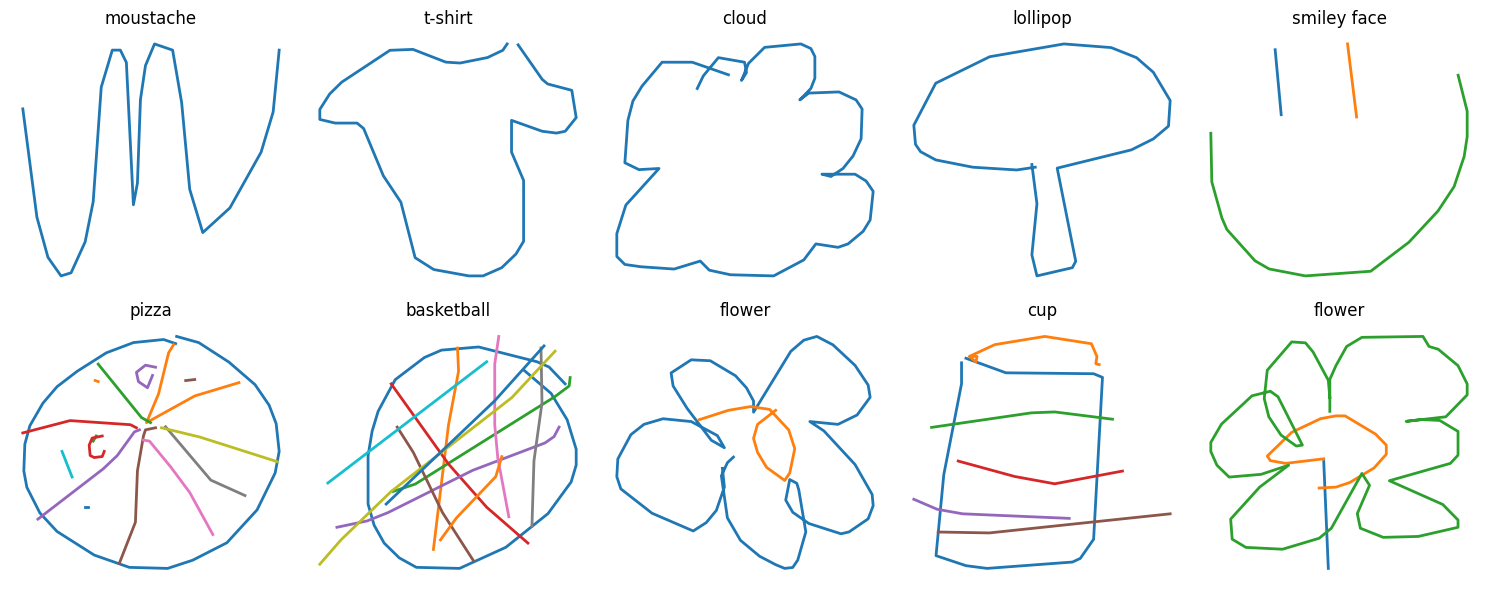

In [9]:
visualizeDrawings(allDrawings, num=10)

We now need to convert the strokes to `[Δx, Δy, pen states]` format so we can pass it into the LSTM model. We also need to pad the strokes to make them have uniform size.

In [10]:
#Function to convert the strokes
def convertStrokes(drawing):
    sequence = []
    prevx, prevy = 0, 0

    for stroke in drawing:
        xseq, yseq = stroke
        for i in range(len(xseq)):
            dx = xseq[i] - prevx
            dy = yseq[i] - prevy
            prevx, prevy = xseq[i], yseq[i]

            if i < len(xseq) - 1:
                pen_state = [1, 0, 0]
            else:
                pen_state = [0, 1, 0]

            sequence.append([dx, dy] + pen_state)

    sequence.append([0, 0, 0, 0, 1])
    return sequence


#Function for padding the strokes
def padStrokes(seq, maxLen):
    if len(seq) >= maxLen:
        return seq[:maxLen]

    pad_len = maxLen - len(seq)
    padding = [[0, 0, 0, 0, 0]] * pad_len
    return seq + padding

In [11]:
finalDrawings = {}

lengths = [len(convertStrokes(d)) for drawings in allDrawings.values() for d in drawings]
maxLen = max(lengths)
print(maxLen)

for className, drawings in allDrawings.items():
    formatted = [convertStrokes(d) for d in drawings]
    padded = [padStrokes(s, maxLen=maxLen) for s in formatted]
    finalDrawings[className] = padded

486


In [12]:
print(len(finalDrawings['crown'][0]))
print(len(finalDrawings['crown']))
print(len(finalDrawings))

486
5000
20


Now we have to start preparing the data for training the model.

In [13]:
X = []
y = []

for className, drawings in finalDrawings.items():
    for drawing in drawings:
        X.append(drawing)
        y.append(className)

print(len(X))
print(len(y))

100000
100000


In [14]:
le = LabelEncoder()
y = le.fit_transform(y)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(len(X))
print(len(y))

100000
100000


In [15]:
print(X.shape)
print(y.shape)

(100000, 486, 5)
(100000,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)

#### Training the model

In [17]:
model = Sequential([
    Input(shape=(486, 5)),
    Masking(mask_value=0.0),

    Bidirectional(LSTM(128, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(32)),
    LayerNormalization(),
    Dropout(0.15),

    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dropout(0.15),

    Dense(20, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [19]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/20
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5056 - loss: 1.6158
Epoch 1: val_loss improved from inf to 0.37490, saving model to best_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 73s 55ms/step - accuracy: 0.5059 - loss: 1.6148 - val_accuracy: 0.8867 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8652 - loss: 0.4679
Epoch 2: val_loss improved from 0.37490 to 0.26795, saving model to best_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - accuracy: 0.8652 - loss: 0.4679 - val_accuracy: 0.9204 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9063 - loss: 0.3266
Epoch 3: val_loss improved from 0.26795 to 0.21944, saving model to best_model.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.9063 - loss: 0.3266 - val_accuracy: 0.9375 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 52

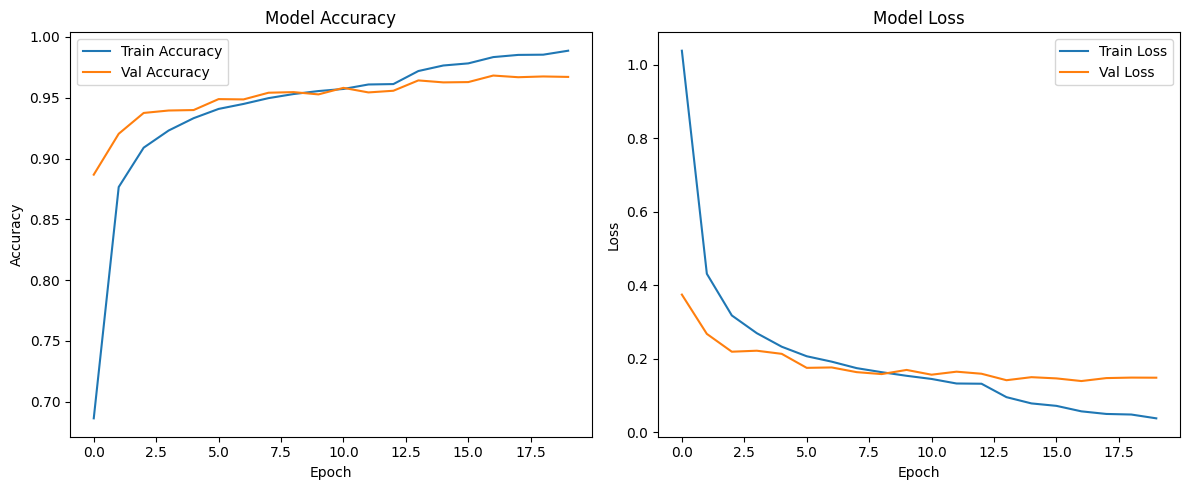

In [20]:
plt.figure(figsize=(12, 5))

#Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9625 - loss: 0.1545
Test Accuracy: 0.9637


625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step


<Figure size 2000x1600 with 0 Axes>

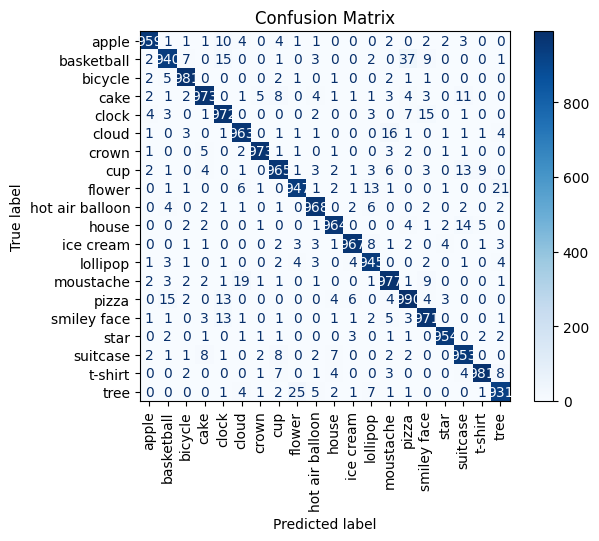

In [22]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [23]:
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

                 precision    recall  f1-score   support

          apple       0.98      0.97      0.97       991
     basketball       0.96      0.92      0.94      1017
        bicycle       0.98      0.98      0.98       996
           cake       0.97      0.95      0.96      1020
          clock       0.94      0.96      0.95      1008
          cloud       0.96      0.97      0.96       995
          crown       0.99      0.98      0.98       991
            cup       0.96      0.95      0.95      1014
         flower       0.96      0.95      0.96       996
hot air balloon       0.97      0.98      0.97       991
          house       0.97      0.97      0.97       996
      ice cream       0.98      0.97      0.97       997
       lollipop       0.95      0.97      0.96       971
      moustache       0.95      0.96      0.95      1021
          pizza       0.94      0.95      0.94      1041
    smiley face       0.95      0.97      0.96      1004
           star       0.99    

In [24]:
model.save("doodle_classifier.keras")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)